In [1]:
pwd

'/home/roman/CODE/tachikoma-analysis/DATA2'

In [2]:
!du -sh /home/roman/mne_data/


60G	/home/roman/mne_data/


In [3]:
import sys, os
from tqdm import tqdm
import torch
import numpy as np
import moabb 
import pandas as pd
from moabb.datasets import (Zhou2016,
                            PhysionetMI,
                            AlexMI,
                            MunichMI,
                            BNCI2014001,
                            BNCI2014002,
                            BNCI2014004,
                            BNCI2015001,
                            BNCI2015004,
                            Cho2017,
                            Weibo2014, 
                            Shin2017A,
                            Ofner2017,
                            Schirrmeister2017)
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io
from termcolor import cprint


from sklearn.pipeline import make_pipeline

import mne
from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from moabb.paradigms import LeftRightImagery, MotorImagery

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
ds = Ofner2017()
print(f'N_subj: {len(ds.subject_list)}')


ChOI = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']
# eventsOI  = ['left_hand', 'right_hand']
eventsOI = ['right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open']

subject_list = ds.subject_list

A = []
MM, XX = [], []

for sid in tqdm(subject_list):
    with HiddenPrints():
        ds.download(subject_list=subject_list)

    events = list(ds.event_id.keys())
    cprint(events, 'red')
    

    n_classes = len(events)
    paradigm = MotorImagery(n_classes=n_classes, 
                            events=events, 
                            tmin=0,
                            tmax=None, #  – End time (in second) of the epoch, relative to the begining of the dataset specific task interval. tmax = 5 would mean the epoch will end 5 second after the begining of the task as defined in the dataset. If None, use the dataset value.
                            baseline=(0, 0.5),
                            channels=None,
                            resample=60, 
                            fmin=0.05,
                            fmax=30) # <<<<<<<<<<

    # get data for all the subjects, sessions and runs in the dataset

    dat = ds.get_data([sid])
    for k in dat[sid].keys():
        for kk in dat[sid][k]:
            ch_names = dat[sid][k][kk].ch_names
            chIDs = np.array([i for i, n in enumerate(ch_names) if n in ChOI])
            A.append(chIDs)
    print(chIDs)

    X__, labels_, meta_ = paradigm.get_data(dataset=ds, subjects=[sid])
    meta_['label'] = labels_
    
    trialsOI = np.where(meta_.label.isin(eventsOI))[0]
    meta = meta_.iloc[trialsOI]#.reset_index(drop=True)
    X_ = X__[trialsOI, :, :]
    X = X_[:, chIDs, :]
    XX.append(X)
    MM.append(meta.to_dict(orient='records'))

    cprint(f'{X.shape}, {np.unique(labels_)}', color='blue')
    



N_subj: 15


  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

[ 0  2  4 29 54 56 58]


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves sur

(240, 7, 180), ['rest' 'right_elbow_extension' 'right_elbow_flexion' 'right_hand_close'
 'right_hand_open' 'right_pronation' 'right_supination']
['right_elbow_flexion', 'right_elbow_extension', 'right_supination', 'right_pronation', 'right_hand_close', 'right_hand_open', 'rest']


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 14/15 [21:23<01:31, 91.70s/it]


ValueError: cannot reshape array of size 392029 into shape (37,newaxis)

In [7]:
MM_ = []
for i in MM:
    for j in i:
        MM_.append(j)
meta = pd.DataFrame(MM_)
samples = np.concatenate(XX, axis=0)

In [8]:
labelsToIDs = {'right_pronation': 0, 'right_hand_close':0, 'right_hand_open':0, 'right_supination':0}

def save_to_torch(samples, meta, ds):
    torch.save({'samples': torch.from_numpy(samples).float(),
                'labels': torch.tensor(meta.label.map(labelsToIDs),  dtype=torch.int64),
                'meta': meta,
                'ChOI': ChOI,
                'eventsOI': eventsOI,
                'Xshape': X.shape},
                f"BNCI{ds.code.replace(' ', '')}.pt")

save_to_torch(samples, meta, ds)

/tmp/ipykernel_26800/2892504398.py:13: RuntimeWarning: Mean of empty slice.
  m = samples[lefts,i,:].mean(0).squeeze()
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


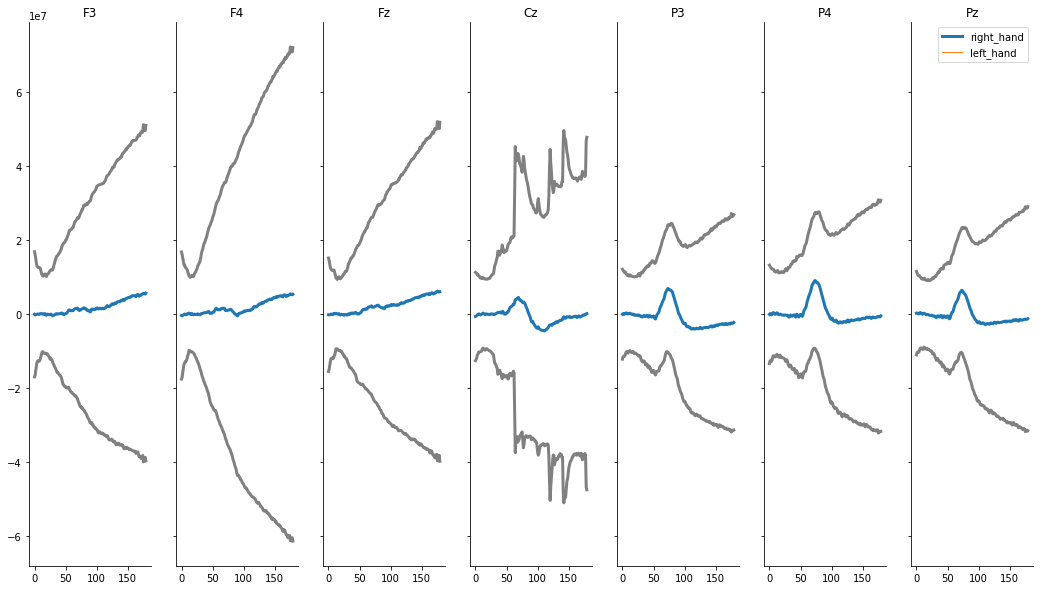

In [9]:
rights = np.where(meta.label.map(labelsToIDs) == 0)[0]
lefts = np.where(meta.label.map(labelsToIDs) == 1)[0]


fix, ax = plt.subplots(1,7, figsize=(18,10), sharey=True)
for i in range(7):
    m = samples[rights,i,:].mean(0).squeeze()
    s = samples[rights,i,:].std(0).squeeze()
    ax[i].plot(m, lw=3, label='right_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=3)
    ax[i].plot(m-s, color='grey', lw=3)
    
    m = samples[lefts,i,:].mean(0).squeeze()
    s = samples[lefts,i,:].std(0).squeeze()
    ax[i].plot(m, lw=1, label='left_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=1)
    ax[i].plot(m-s, color='grey', lw=1)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.right.set_visible(False)

    
    
    ax[i].set_title(['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'][i])

plt.legend()

In [15]:
r = torch.load(f"BNCI{ds.code.replace(' ', '')}.pt") 

In [19]:
r['meta']

,subject,session,run,label
0,1,imagination,run_0,right_pronation
1,1,imagination,run_0,right_hand_close
2,1,imagination,run_0,right_hand_open
3,1,imagination,run_0,right_supination
4,1,imagination,run_0,right_hand_open
...,...,...,...,...
3355,14,imagination,run_9,right_hand_open
3356,14,imagination,run_9,right_supination
3357,14,imagination,run_9,right_hand_close
3358,14,imagination,run_9,right_hand_open
